<a href="https://colab.research.google.com/github/AdvaitDeochakke/SBI_Sentiment_Analysis/blob/main/model_training_senti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AdvaitDeochakke/SBI_Sentiment_Analysis

Cloning into 'SBI_Sentiment_Analysis'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), 104.68 MiB | 10.09 MiB/s, done.


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # GPU/CUDA is available
    print("GPU is available")
    # You can also print the details of the available GPUs
    for gpu in gpus:
        print("GPU Name:", gpu.name)
else:
    # No GPU/CUDA available
    print("GPU is not available")

GPU is available
GPU Name: /physical_device:GPU:0


In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
import pandas as pd
df = pd.read_csv('SBI_Sentiment_Analysis/preprocessed_dataset.csv')
df.target.value_counts()

Negative    748869
Positive    734073
Name: target, dtype: int64

In [6]:
df.head()

,target,Clean
0,Negative,upset cant updat facebook text might cri resul...
1,Negative,dive mani time ball manag save 50 rest go bound
2,Negative,whole bodi feel itchi like fire
3,Negative,behav im mad cant see
4,Negative,whole crew


In [7]:
print(df.isnull().sum())
df.dropna(inplace=True) # clean na

target    0
Clean     1
dtype: int64


In [8]:
# simple train test split

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
print(train_data.target.value_counts())
print(test_data.target.value_counts())


Negative    524643
Positive    513415
Name: target, dtype: int64
Negative    224225
Positive    220658
Name: target, dtype: int64


In [9]:
from gensim.models.phrases import Phraser, Phrases
unigrams = [_.split() for _ in df.Clean]
unigrams[0:5]

[['upset',
  'cant',
  'updat',
  'facebook',
  'text',
  'might',
  'cri',
  'result',
  'school',
  'today',
  'also',
  'blah'],
 ['dive',
  'mani',
  'time',
  'ball',
  'manag',
  'save',
  '50',
  'rest',
  'go',
  'bound'],
 ['whole', 'bodi', 'feel', 'itchi', 'like', 'fire'],
 ['behav', 'im', 'mad', 'cant', 'see'],
 ['whole', 'crew']]

In [10]:
phrases = Phrases(unigrams, min_count=40, progress_per=10000)
bigrams = Phraser(phrases)
sentences = bigrams[unigrams]
sentences[0:5]

In [11]:
# sanity check time ! im not schizo
# get the number of words in the vocabulary
from collections import defaultdict
wrdfreq = defaultdict(int)
for myphrase in sentences:
    for oneword in myphrase:
        wrdfreq[oneword] += 1
len(wrdfreq)

454515

In [12]:
# check the most frequent words
# we removed stopwords, so not seen 'the' is expected
sorted(wrdfreq, key=wrdfreq.get, reverse=True)[:10]

['im', 'go', 'get', 'day', 'work', 'love', 'good', 'like', 'today', 'time']

In [13]:
# for workers in building genshimmodel

import multiprocessing
from gensim.models import Word2Vec

corecount = multiprocessing.cpu_count()
corecount

2

In [14]:
genshinmodel = Word2Vec(
    min_count= 30, # ignores words which appear less than 30 times in the corpora
    window= 7, # context window size
    vector_size= 300, # size of the vector
    sample= 5e-5, # random downsampling of high freq words
    alpha= 0.04, # learning rate
    min_alpha= 0.005, # minimum rate of learning, where it will stop dropping
    negative= 10, # negative sampling for drowning
    workers= corecount-1
)

In [15]:
import time
t = time.time()

# monitor time and build the vocabulary
# mesh them up real good
genshinmodel.build_vocab(sentences, progress_per=10000)
print("\n\ntook time", (time.time()-t), "s")



took time 12.653753519058228 s


In [16]:
t= time.time()
# and now, train it. the important part
# as expected, takes a bit of time.
# more epochs will result in better results as a rule of thumb
# but 30 is fine.
# total examples
genshinmodel.train(
    sentences, # the corpus
    total_examples=genshinmodel.corpus_count, # number of sentences
    epochs=30, # how many epochs to train for
    report_delay=1 # progress report how often, in seconds. can honestly set it to high 10s
    )
print("\n\ntook time", (time.time()-t), "s")



took time 1021.8200531005859 s


In [17]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english') # stemmer for similarity

In [18]:
genshinmodel.wv.most_similar(stemmer.stem('test')) # show the similarity checker

[('exam', 0.564516544342041),
 ('math', 0.5120426416397095),
 ('studi', 0.5028963685035706),
 ('fail', 0.4861163794994354),
 ('oral_exam', 0.46020105481147766),
 ('modul', 0.45380353927612305),
 ('math_gcse', 0.452207088470459),
 ('retak', 0.4450313448905945),
 ('class', 0.43802914023399353),
 ('scienc', 0.43654054403305054)]

In [19]:
# keras modeling.
# i love the simplicity, but not having 12.1 cuda support on my system kinda hurts

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [20]:
# tokenize the inputs
# initiliaze ont he dataset

from keras.preprocessing.text import Tokenizer
tknizer = Tokenizer()
tknizer.fit_on_texts(df.Clean)

In [21]:
# ensure they are of the same length by padding. check pad_sequences docu for various params
# doing simple pre-padding here

from keras.utils import pad_sequences

x_train = pad_sequences(tknizer.texts_to_sequences(train_data.Clean), maxlen=140)
x_test = pad_sequences(tknizer.texts_to_sequences(test_data.Clean), maxlen=140) # twitter absolute max size

print("x_train", x_train.shape)
print("x_test", x_test.shape)

x_train (1038058, 140)
x_test (444883, 140)


In [22]:
# encode labels and transform

from sklearn.preprocessing import LabelEncoder
labels = df.target.unique().tolist()
print(labels)

encoder = LabelEncoder()
encoder.fit(df.target.tolist()) # initialize encoder logic

# the usual
# x -> features
# y -> labels
# we encode the labels

y_train = encoder.transform(train_data.target.tolist()) # encode the target into y_train
y_test = encoder.transform(test_data.target.tolist()) # encode to y_test

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

['Negative', 'Positive']
y_train (1038058, 1)
y_test (444883, 1)


In [23]:
# sanity check
# did we reshape, did we matrixizce the inputs
print(
y_test[0:5],
x_test[0])

[[1]
 [1]
 [0]
 [1]
 [1]] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 1279   44   91  278  283  100   42   52]


In [24]:
import numpy as np
# embed the precious genshim word2vec model

embedding_matrix = np.zeros((len(wrdfreq), 300))
for word, i in tknizer.word_index.items():
  if word in genshinmodel.wv:
    embedding_matrix[i] = genshinmodel.wv[word]

# the embedding matrix maps index to vectors

print(embedding_matrix.shape)

(454515, 300)


In [25]:
embedding_layer = Embedding(len(wrdfreq), 300, weights=[embedding_matrix], input_length=140, trainable=False)

In [31]:
# rest of the model layers
model = Sequential()
model.add(embedding_layer) # to make relevant connections
model.add(Dropout(0.2))
model.add(LSTM(200, dropout=0.2, return_sequences=True)) # multiple LSTM layers
# dropouts prevent overfitting, and lower reliance on regularly occuring words
# encourages to actually learn and not take shortcuts
# afterall, its not a real human, we cant have it take shortcuts
model.add(LSTM(100, recurrent_dropout=0.1, return_sequences=True))
model.add(Dropout(0.15))
# recurrent dropout drops the connection between recurernt cells
# i.e; memory and hidden. captures longer term dependancies
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid')) # sigmoid because we need binary output

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 300)          136354500 
                                                                 
 dropout_2 (Dropout)         (None, 140, 300)          0         
                                                                 
 lstm_5 (LSTM)               (None, 140, 200)          400800    
                                                                 
 lstm_6 (LSTM)               (None, 140, 100)          120400    
                                                                 
 dropout_3 (Dropout)         (None, 140, 100)          0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                

In [33]:
# compile the model

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [28]:
# callback so we dont train forever
# model checkpoint added retrospectively
# now im stuck waiting for this to be finished, which will take forever. Sadge
from keras.callbacks import ModelCheckpoint

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=2e-3, patience=3),
               ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, save_weights_only=False)
               ]

In [34]:
t = time.time()
# train. my system takes ~ 3 hrs or so
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    validation_split=0.12,
                    verbose=1,
                    callbacks=callbacks)

print("time taken", time.time() - t, "s")

Epoch 1/10
893/893 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.7579

893/893 [==============================] - 648s 702ms/step - loss: 0.4947 - accuracy: 0.7579 - val_loss: 0.4595 - val_accuracy: 0.7821 - lr: 0.0010
Epoch 2/10
893/893 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.7807

893/893 [==============================] - 649s 726ms/step - loss: 0.4608 - accuracy: 0.7807 - val_loss: 0.4469 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 3/10
893/893 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.7880

893/893 [==============================] - 643s 720ms/step - loss: 0.4487 - accuracy: 0.7880 - val_loss: 0.4408 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 4/10
893/893 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.7929

893/893 [==============================] - 646s 724ms/step - loss: 0.4405 - accuracy: 0.7929 - val_loss: 0.4377 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 5/10
893/893 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.7968

893/893 [==============================] - 616s 690ms/step - loss: 0.4338 - accuracy: 0.7968 - val_loss: 0.4379 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 6/10
893/893 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.7999

893/893 [==============================] - 633s 709ms/step - loss: 0.4280 - accuracy: 0.7999 - val_loss: 0.4359 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 7/10
893/893 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8022

893/893 [==============================] - 611s 684ms/step - loss: 0.4240 - accuracy: 0.8022 - val_loss: 0.4364 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 8/10
893/893 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8045

893/893 [==============================] - 631s 707ms/step - loss: 0.4201 - accuracy: 0.8045 - val_loss: 0.4355 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 9/10
893/893 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8067

893/893 [==============================] - 630s 705ms/step - loss: 0.4162 - accuracy: 0.8067 - val_loss: 0.4353 - val_accuracy: 0.7974 - lr: 0.0010
Epoch 10/10
893/893 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.8083

893/893 [==============================] - 622s 697ms/step - loss: 0.4129 - accuracy: 0.8083 - val_loss: 0.4341 - val_accuracy: 0.7986 - lr: 0.0010
time taken 6342.21458530426 s


In [35]:
# simple evaluation
score = model.evaluate(x_test, y_test, batch_size=512)
print("accuracy:",score[1])
print("loss:",score[0])

869/869 [==============================] - 57s 65ms/step - loss: 0.4352 - accuracy: 0.7981
accuracy: 0.7980952262878418
loss: 0.43522322177886963


In [38]:
import pickle

# Serialize the objects (x_test and y_test)
serialized_x_test = pickle.dumps(x_test)
serialized_y_test = pickle.dumps(y_test)

# Create a zip file
with zipfile.ZipFile('serialized_data.zip', 'w') as zip_file:
    # Add the serialized objects to the zip file
    zip_file.writestr('x_test.pickle', serialized_x_test)
    zip_file.writestr('y_test.pickle', serialized_y_test)

In [36]:
import zipfile
# lets save the model because we dont want to train it for 2 hours every time we open the notebook
model.save('snetiment_analzyer.h5')
# lets zip it too, so we can save space
with zipfile.ZipFile('snetiment_analzyer.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('snetiment_analzyer.h5')

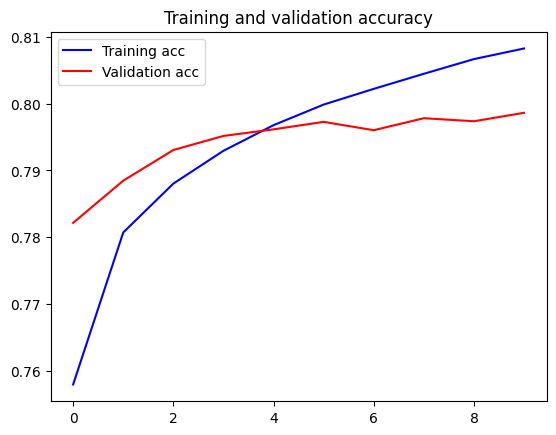

In [41]:
# since we have a history object from earlier, we can plot how our model evolved
# really helpful to see some cool outputs
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # 3 for us, so not real 'graph', just a few points

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [42]:
def score_to_sentiment(score, include_neutral=True):
  if include_neutral:
        label = 'Neutral'
        if score <= 0.42:
            label = 'Negative'
        elif score >= 0.58:
            label = 'Positive'
        return label
  else:
      return 'Negative' if score < 0.5 else 'Positive'

def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tknizer.texts_to_sequences([text]), maxlen=140)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = score_to_sentiment(score, include_neutral)

    return {"text": text, "label": label, "score": float(score)}

In [43]:
predict("I love the music")

1/1 [==============================] - 1s 803ms/step


{'text': 'I love the music', 'label': 'Positive', 'score': 0.9515533447265625}

In [44]:
predict("It's impressive how you always manage to find new ways to avoid taking responsibility.")

1/1 [==============================] - 0s 193ms/step


{'text': "It's impressive how you always manage to find new ways to avoid taking responsibility.",
 'label': 'Neutral',
 'score': 0.5647751092910767}

In [45]:
predict("Every link in Wikipedia is around a six chain away from Hitler")

1/1 [==============================] - 0s 100ms/step


{'text': 'Every link in Wikipedia is around a six chain away from Hitler',
 'label': 'Positive',
 'score': 0.6825700998306274}

In [46]:
predict("My dad beats me, my mom beats me, my friends beat me. But I feel safe with Vitality because they can't beat anyone omeglaul")

1/1 [==============================] - 0s 111ms/step


{'text': "My dad beats me, my mom beats me, my friends beat me. But I feel safe with Vitality because they can't beat anyone omeglaul",
 'label': 'Positive',
 'score': 0.7683548927307129}

In [47]:
predict("doing drugs sucks...")

1/1 [==============================] - 0s 124ms/step


{'text': 'doing drugs sucks...',
 'label': 'Positive',
 'score': 0.5968612432479858}

In [49]:
predict("i hate my life")

1/1 [==============================] - 0s 133ms/step


{'text': 'i hate my life', 'label': 'Negative', 'score': 0.03444806858897209}

In [54]:
# try to add confusion matrix later

# y_pred_1d = []
# y_test_1d = list(test_data.target)
# scores = model.predict(x_test)
# y_pred_1d = [score_to_sentiment(score, include_neutral=False) for score in scores]

InternalError: ignored